<a href="https://colab.research.google.com/github/zahrazfrh733/Tugas-Pa-anam/blob/main/Analisis_Data_Sentimen_Kelompok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sedang melatih model... Mohon tunggu sebentar.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[BERHASIL] File 'hasil_pelabelan_transformer_400.csv' telah disimpan.

--- DAFTAR KESELURUHAN 400 DATA HASIL PREDIKSI ---
                                                         komentar Sentimen
0             Pelayanan di tempat ini sangat memuaskan dan ramah.  Positif
1      Saya merasa sangat terbantu dengan layanan yang diberikan.  Negatif
2                 Kualitas produk sangat baik dan sesuai harapan.  Positif
3                                 Respon admin cepat dan solutif.  Positif
4    Pengalaman saya sangat menyenangkan menggunakan layanan ini.  Positif
5       Fitur yang disediakan sangat lengkap dan mudah digunakan.  Negatif
6                      Saya puas dengan hasil yang saya dapatkan.  Negatif
7                      Aplikasinya berjalan lancar tanpa kendala.   Netral
8                       Pelayanan cepat dan tidak berbelit-belit.  Negatif
9                        Sangat direkome

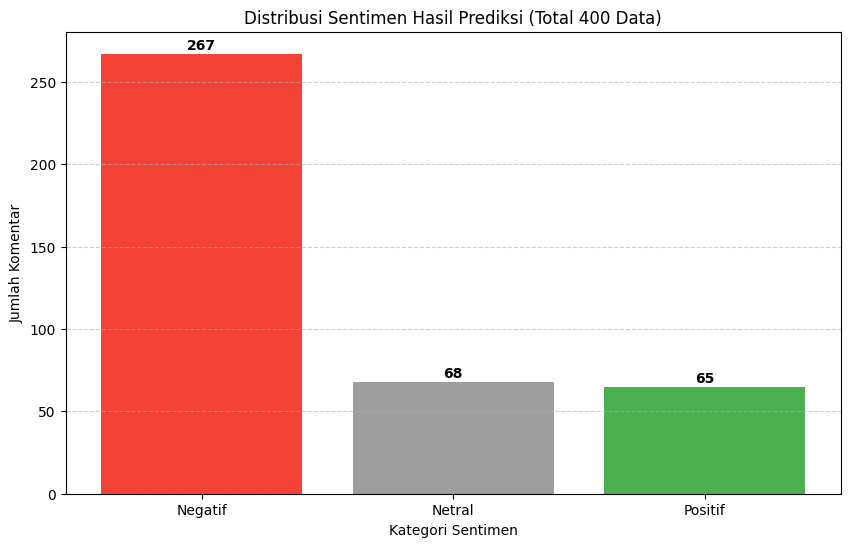

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
df_train = pd.read_csv('pelatihan.csv')
df_test = pd.read_csv('pengujian.csv')

# 2. Preprocessing (Pembersihan Teks)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df_train['clean'] = df_train['Komentar'].apply(clean_text)
df_test['clean'] = df_test['komentar'].apply(clean_text)

# 3. Parameter Model & Label Encoding
vocab_size = 2000
maxlen = 50
embed_dim = 32
num_heads = 2
ff_dim = 32

le = LabelEncoder()
y_train = le.fit_transform(df_train['Sentimen'])
num_classes = len(le.classes_)

# Tokenisasi (Mengubah teks menjadi urutan angka)
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=maxlen
)
vectorize_layer.adapt(df_train['clean'].values)

X_train = vectorize_layer(df_train['clean'].values)
X_test = vectorize_layer(df_test['clean'].values)

# 4. Definisi Arsitektur Transformer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# 5. Build, Train & Predict
inputs = layers.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print("Sedang melatih model... Mohon tunggu sebentar.")
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)

# Prediksi seluruh 400 data
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
df_test['Sentimen'] = le.inverse_transform(predicted_labels)

# 6. SIMPAN HASIL KE CSV (File akan muncul di folder Colab)
df_test[['komentar', 'Sentimen']].to_csv('hasil_pelabelan_transformer_400.csv', index=False)
print("\n[BERHASIL] File 'hasil_pelabelan_transformer_400.csv' telah disimpan.")

# 7. Tampilkan KESELURUHAN 400 DATA (Tanpa Diskip)
print("\n--- DAFTAR KESELURUHAN 400 DATA HASIL PREDIKSI ---")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)
print(df_test[['komentar', 'Sentimen']])

# 8. Tampilkan Grafik Hasil
sentiment_counts = df_test['Sentimen'].value_counts()
plt.figure(figsize=(10, 6))
colors = ['#F44336', '#9E9E9E', '#4CAF50']
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)

# Menambahkan angka jumlah di atas setiap batang grafik
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontweight='bold')

plt.title('Distribusi Sentimen Hasil Prediksi (Total 400 Data)')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Komentar')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()